<a href="https://colab.research.google.com/github/pythonic1exe/Sentiment-Analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow nltk

In [ ]:
import kagglehub, shutil, os

# 1. Download dataset
path = kagglehub.dataset_download("arkhoshghalb/twitter-sentiment-analysis-hatred-speech")
print("Downloaded to:", path)

# 2. Define destination (Colab's sample_data folder)
dest = "/content/sample_data"

# 3. Copy everything from kagglehub folder to sample_data
for file in os.listdir(path):
    src_file = os.path.join(path, file)
    dest_file = os.path.join(dest, file)
    shutil.copy(src_file, dest_file)

print("Files copied to:", dest)


Downloaded to: /root/.cache/kagglehub/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech/versions/1
Files copied to: /content/sample_data


In [ ]:
import pandas as pd

train_df = pd.read_csv('sample_data/train.csv')

label_col = train_df.columns[1]  # 3rd column (0-indexed)

print("Original dataset shape:", train_df.shape)
print(f"Label column: '{label_col}'")
print("Class distribution:")
print(train_df[label_col].value_counts())

# Set random seed for reproducibility
np.random.seed(42)

# Get unique class values
unique_classes = train_df[label_col].unique()
print(f"\nUnique classes: {unique_classes}")

# Sample 2000 from each class
class_samples = []
for class_val in unique_classes:
    class_data = train_df[train_df[label_col] == class_val]
    print(f"Class '{class_val}' has {len(class_data)} samples")

    if len(class_data) >= 2000:
        sampled = class_data.sample(n=2000, random_state=42)
        class_samples.append(sampled)
        print(f"Sampled 2000 from class '{class_val}'")
    else:
        print(f"Warning: Class '{class_val}' has only {len(class_data)} samples, taking all of them")
        class_samples.append(class_data)

# Combine the samples
balanced_df = pd.concat(class_samples, ignore_index=True)

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset shape: {balanced_df.shape}")
print("Balanced class distribution:")
print(balanced_df[label_col].value_counts())

# Now use balanced_df for your NLP processing
train_df = balanced_df

Original dataset shape: (31962, 3)
Label column: 'label'
Class distribution:
label
0    29720
1     2242
Name: count, dtype: int64

Unique classes: [0 1]
Class '0' has 29720 samples
Sampled 2000 from class '0'
Class '1' has 2242 samples
Sampled 2000 from class '1'

Balanced dataset shape: (4000, 3)
Balanced class distribution:
label
0    2000
1    2000
Name: count, dtype: int64


In [ ]:
train_df['label'].value_counts()

,count
label,
0,2000
1,2000


In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2025-09-07 22:26:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2      100%[===================>] 822.24M  5.21MB/s    in 2m 39s  

2025-09-07 22:29:26 (5.17 MB/s) - ‘glove.6B.zip.2’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import numpy as np

words=dict() # empty dictionary to store word embeddings

def add_to_dict(d,filename):
  with open(filename,'r') as file: # open the GloVe file
    for line in file.readlines():  # read line by line
      line = line.split(' ') # line split converts the string to a list separated by spaces

      try:
        d[line[0]] = np.array(line[1:],dtype=float) # word followed by its 50d vector representation
      except:
        continue

In [ ]:
add_to_dict(words,'glove.6B.50d.txt')

In [ ]:
len(words) # length of glove words

400000

In [ ]:
import nltk # for natural language processing nlp

nltk.download('wordnet') # a dictionary(literal) of english words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+') # gives clean tokens without punctuation.

tokenizer.tokenize("@Wassup l'il boy, watchu doin?")

['Wassup', 'l', 'il', 'boy', 'watchu', 'doin']

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() # reduces a word to its lemma which is the dictionary/base form
lemmatizer.lemmatize('feet')

'foot'

In [ ]:
def message_to_token_list(s): # for tokenization and lemmatization
  tokens=tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens] # for lowercasing
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens] # lemmatize the tokens in lowercased form
  useful_tokens = [t for t in lemmatized_tokens if t in words] # useful tokens are only those which also have glove vector embeddings

  return useful_tokens

message_to_token_list("hello brothers, how are ya'll doing?")

['hello', 'brother', 'how', 'are', 'ya', 'll', 'doing']

In [ ]:
def message_to_word_vectors(message,word_dict=words):
  processed_list_of_tokens = message_to_token_list(message) # processed tokens

  vectors = [] # list of vectors initialized

  for token in processed_list_of_tokens: # iterate through every token processed
    if token not in word_dict: # if it is not in glove dictionary skip it
      continue

    token_vector = word_dict[token] # 50d vector embedding of the token
    vectors.append(token_vector) # add it to the list

  return np.array(vectors,dtype=float) # return the list of vectors as a numpy array

In [ ]:
message_to_word_vectors("Me boy").shape # 2 words with 50d vector

(2, 50)

In [ ]:
message_to_word_vectors("Me boy") # vector representation

array([[-0.14525 ,  0.31265 ,  0.15184 , -0.63708 ,  0.63553 , -0.50295 ,
        -0.23214 ,  0.52892 , -0.58629 ,  0.53935 , -0.3055  ,  1.0357  ,
        -0.77989 , -0.19387 ,  1.2215  ,  0.24521 ,  0.26144 ,  0.22439 ,
         0.15584 , -0.79146 , -0.65262 ,  1.3211  ,  0.76618 ,  0.38234 ,
         1.4453  , -2.2643  , -1.1505  ,  0.50373 ,  1.2651  , -1.5903  ,
         3.0518  ,  0.84118 , -0.69543 ,  0.29985 , -0.49151 , -0.22312 ,
         0.59528 , -0.076347,  0.52358 , -0.50134 ,  0.22483 ,  0.01546 ,
        -0.088005,  0.21282 ,  0.28545 , -0.15976 , -0.16777 , -0.50895 ,
         0.14322 ,  1.0118  ],
       [-0.32345 ,  0.23332 , -0.20082 , -0.52848 ,  1.0926  ,  0.62445 ,
        -0.99859 ,  0.28085 ,  0.088326,  0.36919 ,  0.32199 ,  0.3499  ,
         0.067459,  0.24211 ,  0.92565 , -0.32581 , -0.99134 ,  0.80767 ,
        -0.22845 ,  0.40076 , -0.8577  ,  1.3836  ,  0.056439,  0.76561 ,
         0.3608  , -2.0692  , -0.46679 ,  0.12359 ,  0.35127 , -0.77092 ,
       

In [ ]:
# train_df is the variable(df) where we loaded the dataset in the very start
train_df = train_df.sample(frac=1,random_state=1) # shuffle data
train_df.reset_index(drop=True, inplace=True) # re-indexing

split_index_1 = int(len(train_df) * 0.7) #70%
split_index_2 = int(len(train_df) * 0.85) #85%

# training: 70%, validation: 15%, testing: 15%
train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(2800, 600, 600)

In [ ]:
# convert dataset to vector form
def df_to_X_y(dff):
  # target y
  y = dff['label'].to_numpy().astype(int) # convert the labels to numpy array of integers

  all_word_vector_sequences = [] # list for storing vector embeddings of all the words in dataset

  for message in dff['tweet']: # iterate through every message in the dataset
    message_as_vector_seq = message_to_word_vectors(message) # convert the tweet/message to vector form

    if message_as_vector_seq.shape[0]==0: # if no known tokens in glove
      message_as_vector_seq = np.zeros(shape=(1,50)) # write a simple numpy array of 0, 50d, of 1 row

    all_word_vector_sequences.append(message_as_vector_seq) # append to list

  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[0])) # length of training dataset portion and length of first message


2800 9


(array([154., 485., 539., 708., 431., 329., 125.,  24.,   3.,   2.]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ]),
 <BarContainer object of 10 artists>)

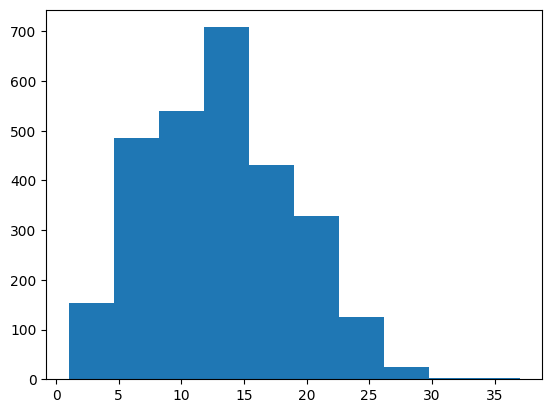

In [ ]:
sequence_length = []

for i in range(len(X_train)): # iterate through whole dataset
  sequence_length.append(len(X_train[i])) # append the word length of ith message to list

import matplotlib.pyplot as plt

# this is to check the word lengths of each message
plt.hist(sequence_length) # histogram

In [ ]:
pd.Series(sequence_length).describe() # tell the facts of the whole X_train dataset

,0
count,2800.000000
mean,13.021786
std,5.626383
min,1.000000
25%,9.000000
50%,13.000000
75%,17.000000
max,37.000000


In [ ]:
# we need every sentence to be of same length because otherwise it will be hard to
# convert to numpy array. So, we will increase the length by adding 0 in place so that
# required length is matched. We set the length to max 57

from copy import deepcopy # for copying

def pad_X(X,desired_sequnece_length=40):
  X_copy = deepcopy(X) # deepcopy of X which is the dataset

  for i, x in enumerate(X): # as every message length different use enumerate to iterate accordingly
    x_seq_length = x.shape[0] # length of message
    sequence_length_difference = desired_sequnece_length - x_seq_length

    pad = np.zeros(shape=(sequence_length_difference,50)) # create a numpy of 0s of size sequence_length_difference

    X_copy[i] = np.concatenate([x,pad]) # concatnate the message with 0 padding so required length is matched

  return np.array(X_copy).astype(float) # return the padded array and convert to type float

In [ ]:
# for 70% training dataset
X_train = pad_X(X_train)

X_train.shape # every message is now of same length

(2800, 40, 50)

In [ ]:
# for 15% validation dataset
X_val, y_val = df_to_X_y(val_df) # convert to vector
X_val = pad_X(X_val) # zero padding

X_val.shape, y_val.shape

((600, 40, 50), (600,))

In [ ]:
# for 15% testing dataset
X_test, y_test = df_to_X_y(test_df) # convert to vector
X_test = pad_X(X_test) # zero padding

X_test.shape, y_test.shape

((600, 40, 50), (600,))

In [ ]:
model.summary() # summary of our architecture

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 40, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 40, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 40, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         2,561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,149 (1.12 MB)

 Trainable params: 98,049 (383.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 196,100 (766.02 KB)

In [ ]:
# LSTM model
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential

model = Sequential([]) # a Sequential model which is a stack of layers applied one after the other.

model.add(layers.Input(shape=(40, 50))) # each input is of words 40 and 50d
model.add(layers.LSTM(64, return_sequences=True)) # 1st lstm layer with 64 hidden units
model.add(layers.Dropout(0.2)) # randmoly drop 20% neurons for regularization
model.add(layers.LSTM(64, return_sequences=True)) # 2nd layer
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True)) # 3rd layer
model.add(layers.Dropout(0.2))
model.add(layers.Flatten()) # takes output of sequnce and flattens it to single vector, helps in dense layer
model.add(layers.Dense(1, activation='sigmoid')) # dense layer outputs 1 or 0 through sigmoid function

In [ ]:
# how model will learn
from keras.losses import BinaryCrossentropy # loss function
from keras.optimizers import Adam # optimizer for how weights are updated
from keras.metrics import AUC # a metric for imbalanced data
from keras.callbacks import ModelCheckpoint # callback to save model

cp = ModelCheckpoint('model/best_model.keras',save_best_only= True) # for saving model, only will be saved once validation improves

model.compile(optimizer = Adam(learning_rate=0.0001), # model with Adam optimizer
              loss = BinaryCrossentropy(), # loss functiom
              metrics = ['accuracy', AUC(name='AUC')]) # metrics of model


In [ ]:
frequencies = pd.value_counts(train_df['label'])

frequencies # how many example of each label in X_train

/tmp/ipython-input-2014568285.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(train_df['label'])


,count
label,
1,1411
0,1389


In [ ]:
# as our dataset is imbalanced, we set the weights accordingly, giving higher weights to rare class
weights = {
    0: frequencies.sum() / frequencies[0], # weight of non hatred
    1: frequencies.sum() / frequencies[1] # weight of hatred
}

weights

{0: np.float64(2.015838732901368), 1: np.float64(1.984408221119773)}

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights) # train model

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - AUC: 0.6427 - accuracy: 0.6039 - loss: 1.3690 - val_AUC: 0.8014 - val_accuracy: 0.7167 - val_loss: 0.6113
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8278 - accuracy: 0.7627 - loss: 1.0800 - val_AUC: 0.8447 - val_accuracy: 0.7433 - val_loss: 0.5112
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8708 - accuracy: 0.7938 - loss: 0.9147 - val_AUC: 0.8636 - val_accuracy: 0.7950 - val_loss: 0.4665
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8897 - accuracy: 0.8132 - loss: 0.8412 - val_AUC: 0.8708 - val_accuracy: 0.8033 - val_loss: 0.4516
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.8919 - accuracy: 0.8258 - loss: 0.8289 - val_AUC: 0.8761 - val_accuracy: 0.8083 - val_loss: 0.4451
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8916 - accuracy: 0.8308 - loss: 0.8253 - val_AUC: 0.8748 - val_accuracy: 0.8000 - val_loss: 0.4661
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

In [ ]:
# 1 epoch is one full pass of the training dataset through the model.

In [ ]:
from keras.models import load_model

best_model = load_model('model/best_model.keras')

In [ ]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       291
           1       0.85      0.86      0.86       309

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

